# Beregning af grundtilstandsenergien af H<sub>2</sub> på en simuleret kvantecomputer vha. Qiskit og variational quantum eigensolver-algoritmen (VQE)

Baseret på artiklen "Scalable Quantum Simulation of Molecular Energies" af O'Malley m.fl. vil vi i denne notebook simulere beregningen af grundtilstandsenergien af H<sub>2</sub> på en kvantecomputer vha. VQE-algoritmen. Meningen er at få et overblik over de forskellige elementer, der indgår i en VQE-beregning. Vi vil bruge en del resultater fra artiklen af O'Malley.

Introduktion: Som grundlag for en VQE-beregning ligger typisk en Hartree-Fock-beregning. Meningen med HF-beregningen er at bestemme de basisfunktioner (orbitaler), der skal bruges til at skrive den elektroniske Hamilton-operator. Hamilton-operatoren skrives typisk i second quantization-formuleringen, som vi ikke kommer ind på her. Her kaldes Hamilton-operatoren den fermioniske Hamilton-operator. Efter at den fermioniske Hamilton-operator er klar, skal den omskrives til en sum af Pauli-strenge. Det bliver i artiklen gjort vha. Bravyi-Kitaev-transformationen. Grunden til omskrivningen er, at vi skal have Hamilton-operatoren på en form, hvor forventningsværdien kan beregnes på en kvantecomputer. Den transformerede form af Hamilton-operatoren kaldes qubit Hamilton-operatoren. I artiklen er transformeringen lavet for os, og Hamilton-operatoren viser sig at kunne skrives som $H = g_0 I + g_1 Z_0 + g_2 Z_1 + g_3 Z_0 Z_1 + g_4 Y_0 Y_1 + g_5 X_0 X_1$. $g_i$ er koefficienter eller vægte, der - for en bindingsafstand på $0.75 \, \mathrm{Å}$ i H<sub>2</sub>-molekylet og med STO-6G-basissættet brugt til HF-beregningen - har værdierne $g_0 = -0.4804$, $g_1 = 0.3435$, $g_2 = -0.4347$, $g_3 = 0.5716$, $g_4 = 0.0910$, $g_5 = 0.0910$ (fra O'Malley). Hamilton-operatoren involverer kun to qubits, så vi behøver kun to qubits i vores kvantekredsløb til at køre VQE-beregningen.

1) Forbered et kredsløb med to qubits.

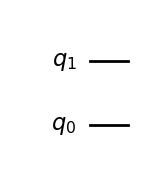

In [7]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.draw("mpl", reverse_bits=1)

2) Tilstanden $\ket{01}$ svarer ifølge O'Malley til HF-tilstanden for den ovennævnte qubit Hamilton-operator. Så vi forbereder denne tilstand, inden vi anvender vores ansatz.

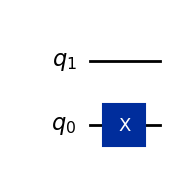

In [8]:
qc.x(0)
qc.draw("mpl", reverse_bits=1)

3) Nu til ansatzen. I artiklen bruges en unitary coupled cluster ansatz, som kan implementeres med nedenstående gates (se det tegnede kredsløb). Der er kun én variabel, $\theta$, som bruges som rotationsvinkel for $R_z$-gaten. Vi ønsker at finde den værdi af $\theta$, som minimerer forventningsværdien af qubit Hamilton-operatoren. Når den optimale $\theta$ er fundet, har vi grundtilstandsenergien af molekylet i henhold til variationsprincippet.

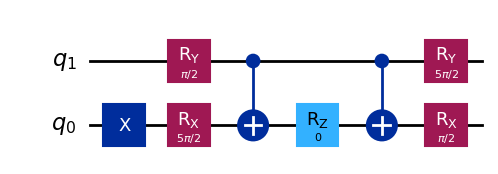

In [9]:
import numpy as np

theta = 0
qc.barrier()

def ApplyAnsatz(theta):
    qc.ry(np.pi / 2, 1)
    qc.rx(5 * np.pi / 2, 0)
    qc.cx(1, 0)
    qc.rz(theta, 0)
    qc.cx(1, 0)
    qc.rx(np.pi / 2, 0)
    qc.ry(5 * np.pi / 2, 1)

ApplyAnsatz(theta)

qc.draw("mpl", reverse_bits=1, plot_barriers=0)

4) Vi vil nu simulere kredsløbet. I stedet for at bruge en optimeringsalgoritme til at finde den optimale $\theta$, looper vi i stedet over værdier mellem $0$ og $2\pi$.

In [10]:
from qiskit.quantum_info import Pauli
from qiskit_aer.primitives import Estimator

def CalculateEnergy(ev):
    g0, g1, g2, g3, g4, g5 = -0.4804, 0.3435, -0.4347,  0.5716, 0.0910, 0.0910
    return g0 + g1 * ev[0] + g2 * ev[1] + g3 * ev[2] + g4 * ev[3] + g5 * ev[4]

operators = [Pauli("IZ"), Pauli("ZI"), Pauli("ZZ"), Pauli("YY"), Pauli("XX")]
estimator = Estimator()
energies = []
thetas = []

niter = 100
for i in range(niter):
    thetas.append((i * 2 * np.pi) / niter)
    qc.reset(range(2))
    qc.x(0)
    ApplyAnsatz(thetas[i])
    job = estimator.run(len(operators) * [qc], operators, shots = 512)
    energies.append(CalculateEnergy(job.result().values))

5) Vi kan nu plotte den elektroniske energi som funktion af $\theta$.

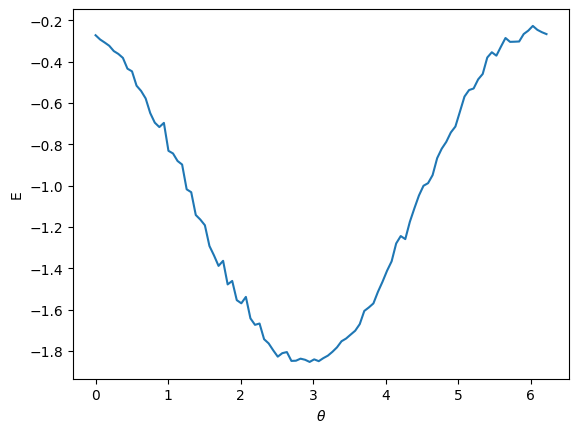

In [11]:
from matplotlib import pyplot as plt

plt.plot(thetas, energies)
plt.xlabel(r'$\theta$')
plt.ylabel("E")
plt.show()

6) Grundtilstandsenergien af H<sub>2</sub>-molekylet er nu fundet vha. VQE-algoritmen.

In [12]:
gsEnergy = 0
optimalTheta = 0

for i in range(len(energies)):
    if energies[i] < gsEnergy:
        gsEnergy = energies[i]
        optimalTheta = thetas[i]

nuclearRepulsion = 0.7055696146 # joshuagoings
exact = -1.1457416808 # joshuagoings
print("Grundtilstandsenergien af hydrogen ifølge VQE:", f'{gsEnergy + nuclearRepulsion : .7f}')
print("Eksakt energi:", f'{exact : .7f}')
print("Abs. forskel:", f'{abs(exact - gsEnergy - nuclearRepulsion) : .7f}')
print("Den optimale variationelle parameter, theta:", f'{optimalTheta : .7f}')

Grundtilstandsenergien af hydrogen ifølge VQE: -1.1467554
Eksakt energi: -1.1457417
Abs. forskel:  0.0010137
Den optimale variationelle parameter, theta:  2.9530971


# Vi har nu kørt en VQE-algoritme på en simuleret, støjfri kvantecomputer. Hvis det skulle være helt rigtigt, skulle vi have også have inkluderet støj og error mitigation. Men det må blive en anden gang.